In [79]:
#Ref1: https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/
#Ref2: https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/

from pickle import load

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import os
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import keras
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

from keras import backend as K
from keras import __version__
print('Using Keras version:', __version__, 'backend:', K.backend())

Using Keras version: 2.4.3 backend: tensorflow


In [80]:
def read_dataset(file_path):
    #Open from .txt files
    dataset = []
    with open(file_path, encoding='utf-8') as f:
        dataset = f.readlines()
        f.close()
    return dataset

def split_input_target(dataset):
    datasetLength = len(dataset)

    # Split into English Sentence and Portuguese Sentences
    eng_sen =  [] #English Sentence
    port_sen =  [] #Portuguese Sentence

    for line in dataset:
        splited = line.split('|')
        eng_sen.append(splited[0])
        port_sen.append(splited[1])

    return [eng_sen, port_sen]


In [81]:
def cleaning_punctuation_and_uppercase(sentence_list):
    sentence_list  = [(sen.translate(str.maketrans('', '', string.punctuation))).lower() for sen in sentence_list]
    return sentence_list

def visualize_length_of_sentences(title, senX, senY):
    senX = [len(sen.split()) for sen in senX]
    senY = [len(sen.split()) for sen in senY]
    length_df = pd.DataFrame({'English': senX, 'Portuguese': senY})
    length_df.hist(bins = 30)
    plt.xticks(range(0, 15, 1))
    plt.xlabel('#Word', fontsize=18)
    plt.ylabel('#Sentences', fontsize=16)
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    #fig.save(title+".jpg")
    plt.show()

In [82]:
def tokenizer(sentence_list):
    tok = tf.keras.preprocessing.text.Tokenizer()
    tok.fit_on_texts(sentence_list)
    return  tok #tok.sequences_to_matrix(tok.texts_to_sequences(sentence_list), mode='tfidf')

# Text Encoding into sequences and pad to make equal feature length to Train NN
def encode_text_to_sequences(tokenizer, max_sen_length, sentence_list):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(sentence_list)
    # pad sequences with 0 values
    seq = keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_sen_length, padding='post')
    return seq
    

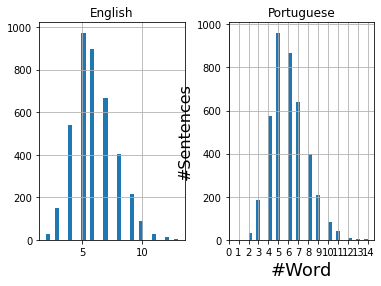

<Figure size 432x288 with 0 Axes>

English Vocabulary Size: 2437
:Portugese Vocabulary Size: 3183
[[119   6 781 ...   0   0   0]
 [  1 652 182 ...   0   0   0]
 [ 28   2 101 ...   0   0   0]
 ...
 [ 44 142   4 ...   0   0   0]
 [ 18   9  13 ...   0   0   0]
 [ 63 902  42 ...   0   0   0]]
[[   4  128 1003 ...    0    0    0]
 [   7  656    5 ...    0    0    0]
 [   1   55  135 ...    0    0    0]
 ...
 [1921   12    2 ...    0    0    0]
 [  16    5  107 ...    0    0    0]
 [  19   37  902 ...    0    0    0]]


In [83]:
    dataset = read_dataset("dataset_1.txt")
    eng_sen, port_sen = split_input_target(dataset)
    

    #Cleaning
    eng_sen = cleaning_punctuation_and_uppercase(eng_sen)
    port_sen = cleaning_punctuation_and_uppercase(port_sen)

    #Plot Sentences
    visualize_length_of_sentences("modified dataset1", eng_sen, port_sen)

    #tokenize
    eng_tok = tokenizer(eng_sen)
    port_tok = tokenizer(port_sen)

    #Max word length in Sentence
    max_eng_sen_word_length  = 15
    max_port_sen_word_length = 15

    #Vocab Size
    eng_vocab_size = len(eng_tok.word_index)+1
    port_vocab_size = len(port_tok.word_index)+1

    #print
    print('English Vocabulary Size: %d' % eng_vocab_size)
    print(':Portugese Vocabulary Size: %d' % port_vocab_size)

    #encoding text to sequence
    eng_encoded_seq = encode_text_to_sequences(eng_tok, max_eng_sen_word_length, eng_sen)
    port_encoded_seq = encode_text_to_sequences(port_tok, max_port_sen_word_length, port_sen)

    #print
    print(eng_encoded_seq)
    print(port_encoded_seq)


In [84]:
from sklearn.model_selection import train_test_split


# split data into train and test set
train, test = train_test_split(eng_por, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_text_to_sequences(eng_tok, max_eng_sen_word_length, train[:, 1])
trainY = encode_text_to_sequences(port_tok, max_port_sen_word_length, train[:, 0])

# prepare validation data
testX = encode_text_to_sequences(eng_tok, max_eng_sen_word_length, test[:, 1])
testY = encode_text_to_sequences(port_tok, max_port_sen_word_length, test[:, 0])

In [85]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, hidden_size):
  use_dropout = True
  model = Sequential()
  model.add(Embedding(src_vocab, hidden_size, input_length = src_timesteps))
  model.add(LSTM(hidden_size))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(hidden_size, return_sequences=True))
  if use_dropout:
    model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(tar_vocab, activation = 'softmax')))
  
  return model

# define model
model = define_model(eng_vocab_size, port_vocab_size, max_eng_sen_word_length, max_port_sen_word_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 15, 256)           623872    
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 15, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 15, 256)           525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 256)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 3183)          818031    
Total params: 2,492,527
Trainable params: 2,492,527
Non-trainable params: 0
____________________________________________

In [86]:
filename = 'model.h1.01_apr_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Epoch 1/30


ValueError: ignored